### setup

In [1]:
from cvxpy import *
from datetime import datetime
from EbolaSimulator import*
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

%matplotlib inline

%load_ext autoreload
%autoreload 2

### load graph model from file

In [2]:
graph = pickle.load(open(os.getcwd()+'/ebola_graph.pkl' ,'rb'))

### run simulations

In [ ]:
# simulation parameters
# alpha = 0.7
# eta = 0
# eta = 0.10
# alpha = 1/1.17
# beta = 1
# eta = 0

alpha = 0.14
beta = (1/1.17)*0.15
parameters = {}
parameters['alpha'] = alpha
parameters['beta'] = beta
# parameters['eta'] = eta

init = {}
init[('guinea','gueckedou')] = 1

plot_data = {}

In [ ]:
sim = EbolaSimulator(graph, init, parameters, rng=1)
for k in sim.states.keys():
    plot_data[k] = []
    plot_data[k].append(sim.states[k]['value'])
    
trigger_data = 55
    
while not sim.end:
    action = []
    if sim.iter > trigger_data:
        for k in graph.keys():
            action.append(k)
        
    sim.step(action)
    for k in sim.states.keys():
        plot_data[k].append(sim.states[k]['value'])
    
#for k in sorted(sim.states.keys()):
#    print('%03d : %s %s' %(sim.states[k]['value'],k,sim.states[k]['status']))

dt = [sim.states[k]['value'] for k in sim.states.keys()]
print('mean infection time: %0.2f' %np.mean(dt))
print('median infection time: %0.2f' %np.median(dt))

plt.boxplot(dt, showmeans=True)

In [ ]:
k = ('liberia','montserrado')
k = ('guinea','gueckedou')
t = [t for t in range(len(plot_data[k]))]
v = [0.0001*el for el in plot_data[k]]
plt.plot(t, v)

check statistics for simulation run many times

In [ ]:
st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_data = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter > trigger_data:
            for k in graph.keys():
                action.append(k)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_data.append(np.mean(dt))


st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

In [ ]:
print('median dT over %d trials: %0.2f' %(len(dt_data),np.median(dt_data)))

### method parameters

In [3]:
gamma = 0.9
sigma = -1
deg = 4
capacity = 3
trigger_methods = 5

alpha = 0.14
beta = (1/1.17)*0.15
parameters = {}
parameters['alpha'] = alpha
parameters['beta'] = beta

init = {}
init[('guinea','gueckedou')] = 1

### approximate value function method

basis functions: $w_{0} + w_{1}\textbf{1}_{S}(x_{e}^{t}) + w_{2}\textbf{1}_{S}(x_{i}^{t})\sum_{j\in N(i)}\textbf{1}_{E}(x_{j}^{t}) + w_{3}\textbf{1}_{E}(x_{i}^{t})$

reward: $r_{i} = \textbf{1}_{S}(x_{i}^{t+1})(1-\alpha e_{i}^{t+1}) + \sigma\textbf{1}_{E}(x_{i}^{t+1})$

In [12]:
phi = Variable()
w = Variable(4)
objective = Minimize(phi)
constraints = []

for i in [0,1,2]:
    if i == 0:
        
        for vi in range(deg+1):
            for ei in range(deg+1-vi):
                
                for ej_sum in range((deg-1)*vi+1):
                    for a in range(ei+1):
                        if a == 0:
                            constraints += [phi >= w[0] + w[1] + w[2]*ei - 
                                            (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) - (sigma*alpha*ei) -
                                            gamma*w[0]-gamma*w[1]*(1-alpha*ei) - 
                                            gamma*w[2]*(1-alpha*ei)*(alpha*ej_sum+ei-beta*a) - 
                                            gamma*w[3]*alpha*ei]
                    
                        constraints += [phi >= -w[0] - w[1] - w[2]*ei + 
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) + (sigma*alpha*ei) +
                                        gamma*w[0]-gamma*w[1]*(1-alpha*ei) +
                                        gamma*w[2]*(1-alpha*ei)*(alpha*ej_sum+ei-beta*a) +
                                        gamma*w[3]*alpha*ei]

    elif i == 1:
        
        for ei in range(deg+1):
            for a in [0,1]:

                if a == 0:
                    constraints += [phi >= w[0] + w[3] -
                                    (sigma*(1-beta*a)) - gamma*w[0] - gamma*w[3]*(1-beta*a)]
                    
                constraints += [phi >= -w[0] - w[3] +
                                (sigma*(1-beta*a)) + gamma*w[0] + gamma*w[3]*(1-beta*a)]
                
    elif i == 2:
        constraints += [phi >=  w[0] - gamma*w[0]]
        constraints += [phi >= -w[0] + gamma*w[0]]


problem = Problem(objective, constraints)
print('number of constraints: %d' %len(constraints))

number of constraints: 232


In [13]:
result = problem.solve()
print('problem status: %s' %problem.status)
print('error: %0.4f' %problem.value)
print('weight(s): ')
print(w.value)

problem status: optimal
error: 0.3436
weight(s): 
[[-3.43603059]
 [ 0.52631579]
 [-0.83022057]
 [-3.12793881]]


In [14]:
def vw(states, graph, capacity, weights, alpha, beta, gamma, sigma):
    control = []
    for k in states.keys():
        if states[k]['status'] == 'infected':
            ni = 0
            for el in graph[k]['edges']:
                if states[el]['status'] == 'susceptible':
                    nj = 0
                    for ek in graph[el]['edges']:
                        if states[ek]['status'] == 'infected':
                            nj += 1
                    ni += (1-alpha*nj)
            
            value = (alpha + gamma*weights[2])*beta*ni - (sigma + gamma*weights[3])*beta
            control.append((value,k))
            
    control = sorted(control)[:capacity]
    control = [el[1] for el in control]
            
    return control


min infection time: 0.00
median infection time: 23.00
max infection time: 119.00


{'boxes': [<matplotlib.lines.Line2D at 0x7fb6fcd2d048>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb6fcd31860>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb6fcd35c88>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb6fcd35470>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb6fcd2da20>,
  <matplotlib.lines.Line2D at 0x7fb6fcd2dba8>]}

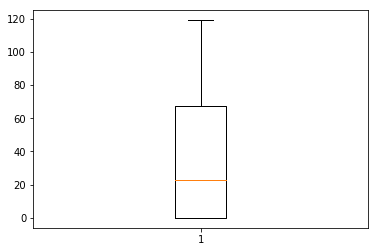

In [15]:
# weights_vw = [-4.91, 1.22, -0.28, -0.17]
weights_vw = [-3.43, 0.526, -0.83, -3.12]

init = {}
init[('guinea','gueckedou')] = 1

sim = EbolaSimulator(graph, init, parameters, rng=1)

while not sim.end:
    action = []
    if sim.iter > trigger_methods:
        action = vw(sim.states, graph, capacity, weights_vw, alpha, beta, gamma, sigma)
        
    sim.step(action)
    
dt = [sim.states[k]['value'] for k in sim.states.keys()]
print('min infection time: %0.2f' %np.amin(dt))
print('median infection time: %0.2f' %np.median(dt))
print('max infection time: %0.2f' %np.amax(dt))

plt.boxplot(dt)

benchmark vw method

In [28]:
st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_vw = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter > trigger_methods:
            action = vw(sim.states, graph, capacity, weights_vw, alpha, beta, gamma, sigma)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_vw.append(np.median(dt))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-17 17:55:57] start
[2018-03-17 17:56:17] finish
19.46s = 0.32m elapsed


min: 0.00
median: 30.00
max: 103.00


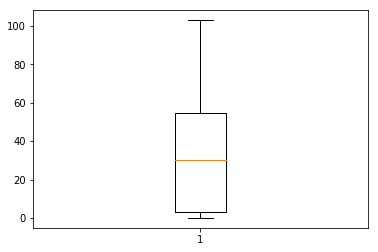

In [29]:
plt.boxplot(dt_vw)

print('min: %0.2f' %np.amin(dt_vw))
print('median: %0.2f' %np.median(dt_vw))
print('max: %0.2f' %np.amax(dt_vw))

### approximate Q function method

basis function: $w_{0} + w_{1}\textbf{1}_{S}(x_{i}^{t}) + w_{2}\textbf{1}_{E}(x_{i}^{t}) + a_{i}^{t}w_{3}\textbf{1}_{E}(x_{i}^{t})\sum_{j\in N(i)} \textbf{1}_{S}(x_{j}^{t})$

reward: $r_{i} = \textbf{1}_{S}(x_{i}^{t+1})(1-\alpha e_{i}^{t+1}) + \sigma\textbf{1}_{E}(x_{i}^{t+1})$

In [41]:
phi = Variable()
w = Variable(4)
objective = Minimize(phi)
constraints = []

for i in [0,1,2]:
    if i == 0:
        
        for vi in range(deg+1):
            for ei in range(deg+1-vi):
                for ej_sum in range((deg-1)*vi+1):
                    for aj in range(ei+1):
                        
                        constraints += [phi >= w[0]+w[1] -
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*aj)) - (sigma*alpha*ei) -
                                        gamma*w[0] - gamma*w[1]*(1-alpha*ei) - gamma*w[2]*alpha*ei]

                        constraints += [phi >= -w[0]-w[1] +
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*aj)) + (sigma*alpha*ei) +
                                        gamma*w[0] + gamma*w[1]*(1-alpha*ei) + gamma*w[2]*alpha*ei]

                        constraints += [phi >= -w[0]-w[1] +
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*aj)) + (sigma*alpha*ei) +
                                        gamma*w[0] + gamma*w[1]*(1-alpha*ei) + gamma*w[2]*alpha*ei]

    elif i == 1:
        
        for ai in [0,1]:
            for vi in range(deg+1):
                for k in range(2**(vi*(deg-1))):
                    xk = np.base_repr(k, base=2).zfill(deg*(deg-1))
                    
                    smallsum = 0
                    bigsum = 0
                    for j in range(vi):
                        ej = xk[(deg-1)*j:(deg-1)*(j+1)].count('1')
                        smallsum += (1-alpha*ej)
                        
                        for idx in range(deg-1):
                            if xk[(deg-1)*j+idx] == '0':
                                for ek in range(deg+1):
                                    bigsum += (1-alpha*ej)*(1-alpha*(1-alpha*ek))
                            else:
                                for ak in [0,1]:
                                    bigsum += (1-alpha*ej)*(1-alpha*(1-beta*ak))
                                    
                    constraints += [phi >= w[0]+w[2]+w[3]*ai*smallsum -
                                    (sigma*(1-beta*ai)) -
                                    gamma*w[0] - gamma*w[2]*(1-beta*ai)]

                    constraints += [phi >= -w[0]-w[2]-w[3]*ai*smallsum +
                                    (sigma*(1-beta*ai)) +
                                    gamma*w[0] + gamma*w[2]*(1-beta*ai)]

                    constraints += [phi >= -w[0]-w[2]-w[3]*ai*smallsum +
                                    (sigma*(1-beta*ai)) +
                                    gamma*w[0] + gamma*w[2]*(1-beta*ai) + 
                                    gamma*w[3]*(1-beta*ai)*bigsum] #(alpha*ej_sum)

    elif i == 2:
        constraints += [phi >=  w[0] - gamma*w[0]]
        constraints += [phi >= -w[0] + gamma*w[0]]


problem = Problem(objective, constraints)
print('number of constraints: %d' %len(constraints))

number of constraints: 28508


In [42]:
result = problem.solve()
print('problem status: %s' %problem.status)
print('error: %0.4f' %problem.value)
print('weight(s): ')
print(w.value)

problem status: optimal
error: 0.9475
weight(s): 
[[ 4.44568159]
 [-3.92117828]
 [-4.97018491]
 [-0.07732115]]


In [37]:
def Qw(states, graph, capacity, weights, alpha, beta, gamma, sigma):
    control = []
    for k in states.keys():
        if states[k]['status'] == 'infected':
            ni = 0
            for el in graph[k]['edges']:
                if states[el]['status'] == 'susceptible':
                    nj = 0
                    for ek in graph[el]['edges']:
                        if states[ek]['status'] == 'infected':
                            nj += 1
                    ni += (1-alpha*nj)
            
            value = gamma*weights[3]*ni
            control.append((value,k))
            
    control = sorted(control)[:capacity]
    control = [el[1] for el in control]
            
    return control

In [38]:
# weights_Qw = [6.41, -5.89, -6.94, 0.0412]
weights_Qw = [4.44, -3.92, -4.97, -0.0773]

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_Qw = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter > trigger_methods:
            action = Qw(sim.states, graph, capacity, weights_Qw, alpha, beta, gamma, sigma)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_Qw.append(np.median(dt))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-17 19:12:04] start
[2018-03-17 19:12:24] finish
19.73s = 0.33m elapsed


min: 0.00
median: 30.00
max: 103.00


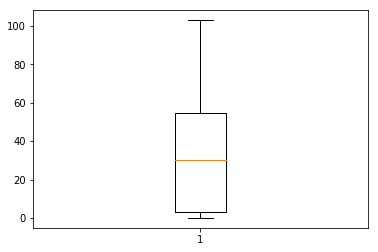

In [39]:
plt.boxplot(dt_Qw)

print('min: %0.2f' %np.amin(dt_Qw))
print('median: %0.2f' %np.median(dt_Qw))
print('max: %0.2f' %np.amax(dt_Qw))

### implement and benchmark Forsell et al. basis functions

In [4]:
phi = Variable()
w = Variable(3)
objective = Minimize(phi)
constraints = []

for i in [0,1,2]:
    if i == 0:
        
        for vi in range(deg+1):
            for ei in range(deg+1-vi):
                
                for ej_sum in range((deg-1)*vi+1):
                    for a in range(ei+1):
                        
                        if i == 0:
                            constraints += [phi >= w[0] - 
                                            (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) - (sigma*alpha*ei) - 
                                            gamma*w[0]*(1-alpha*ei) - gamma*w[1]*alpha*ei]
                        
                        constraints += [phi >= -w[0] + 
                                        (1-alpha*ei)*(1-alpha*(alpha*ej_sum+ei-beta*a)) + (sigma*alpha*ei) +
                                        gamma*w[0]*(1-alpha*ei) + gamma*w[1]*alpha*ei]
                        
    if i == 1:
        
        for ei in range(deg+1):
            for a in [0,1]:
                if a == 0:
                    constraints += [phi >= w[1] - 
                                    (sigma*(1-beta*a)) - gamma*w[1]*(1-beta*a) - gamma*w[2]*beta*a]
                    
                constraints += [phi >= -w[1] + 
                                (sigma*(1-beta*a)) + gamma*w[1]*(1-beta*a) + gamma*w[2]*beta*a]
                
    if i == 2:
        
        constraints += [phi >=  w[2] - gamma*w[2]]
        constraints += [phi >= -w[2] + gamma*w[2]]
                
        
problem = Problem(objective, constraints)
print('number of constraints: %d' %len(constraints))

number of constraints: 297


In [5]:
result = problem.solve()
print('problem status: %s' %problem.status)
print('error: %0.4f' %problem.value)
print('weight(s): ')
print(w.value)

problem status: optimal
error: 0.9475
weight(s): 
[[ 0.52450331]
 [-0.52450331]
 [-0.73672369]]


In [6]:
def priorwork(states, graph, capacity, weights, alpha, beta, gamma, sigma):
    control = []
    for k in states.keys():
        if states[k]['status'] == 'infected':
            ni = 0
            for el in graph[k]['edges']:
                if states[el]['status'] == 'susceptible':
                    nj = 0
                    for ek in graph[el]['edges']:
                        if states[ek]['status'] == 'infected':
                            nj += 1
                    ni += (1-alpha*nj)
            
            value = alpha*beta*ni + (-sigma*beta - gamma*weights[1]*beta + gamma*weights[2]*beta)
            control.append((value,k))
            
    control = sorted(control)[:capacity]
    control = [el[1] for el in control]
            
    return control

In [24]:
weights_prior = [0.52, -0.52, -0.736]

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()
dt_prior = []
for s in range(1000):
    sim = EbolaSimulator(graph, init, parameters, rng=s+1000)

    while not sim.end:
        action = []
        if sim.iter > trigger_methods:
            action = priorwork(sim.states, graph, capacity, weights_prior, alpha, beta, gamma, sigma)

        sim.step(action)
        
    dt = [sim.states[k]['value'] for k in sim.states.keys()]
    dt_prior.append(np.median(dt))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-17 17:54:47] start
[2018-03-17 17:55:08] finish
21.04s = 0.35m elapsed


min: 0.00
median: 65.50
max: 104.00


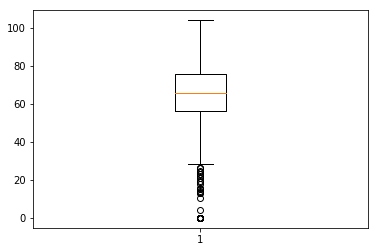

In [25]:
plt.boxplot(dt_prior)

print('min: %0.2f' %np.amin(dt_prior))
print('median: %0.2f' %np.median(dt_prior))
print('max: %0.2f' %np.amax(dt_prior))

### scratch code

In [ ]:
        
        for vi in range(deg+1):
            for ei in range(deg+1-vi):
                for ej_sum in range((deg-1)*vi+1):
                    
                    for ai in [0,1]:
                        for aj in range(ei+1):
                            constraints += [phi >= w[0]+w[2]+w[3]*ai*vi -
                                            (sigma*(1-beta*ai)) -
                                            gamma*w[0] - gamma*w[2]*(1-beta*ai)]

                            constraints += [phi >= -w[0]-w[2]-w[3]*ai*vi +
                                            (sigma*(1-beta*ai)) +
                                            gamma*w[0] + gamma*w[2]*(1-beta*ai)]

                            constraints += [phi >= -w[0]-w[2]-w[3]*ai*vi +
                                            (sigma*(1-beta*ai)) +
                                            gamma*w[0] + gamma*w[2]*(1-beta*ai) + 
                                            gamma*w[3]*(1-beta*ai)*(alpha*ej_sum)]
                